# Gaussian Processes Inferencing in Stingray

## Gaussian Processes in Astronomy

Gaussian Processes (GPs) are powerful class of Statistical Models, that help us model both the deterministic and stochastic part of a random process. We model the covaraince between pairs of samples (using the kernel function) and the underlying deterministic function (using the mean function) fit or infer from the data set. 

GP Regression and inferencing (GPR) has become increasingly popular in the astronomical community over the last decade as it can model non-trivial random or unkown signals. Sometimes, we are interested in the stochastic behaviour itself, and we can
infer its characteristics or predict its behaviour using Gaussian Processes.


While we can use GP's to produce models for various signals, we often have to identify if the particular time-series has a particular signal we resort to Bayesian Model Comparison. In it, we compare two model by the Bayes factor, which is the ratio of the evidences of two comparing models. Since Evidence Calculation is a difficult problem, we will use Nested Sampling, using Jaxns library to get the Bayes Factor.


## Sample Lightcurve
As an example demonstrating the use of gpmodeling in Stingray, we will make a sample lightcurve based on a QPO (quasi periodic signal), and use the ratio of Evidence of the following two models to identify whether the signal contains a Quasi-Periodic Signal or not.
1. RN (Red-Noise) model, which has a Red noise kernel and Gaussian function for its mean.
2. QPO_plus_Rn (QPO + RN) model, which uses a QPO kernel and a double skew gaussian function for its mean.



In [1]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
# import seaborn as sns
# sns.set_style('whitegrid')

from tinygp import GaussianProcess, kernels
from stingray import Lightcurve

jax.config.update("jax_enable_x64", True)

/Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/stingray/utils.py:50: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


INFO[2023-07-20 02:07:59,335]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-07-20 02:07:59,336]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-07-20 02:07:59,337]: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO[2023-07-20 02:08:01,521]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-07-20 02:08:01,522]: Checking if light curve is sorted.


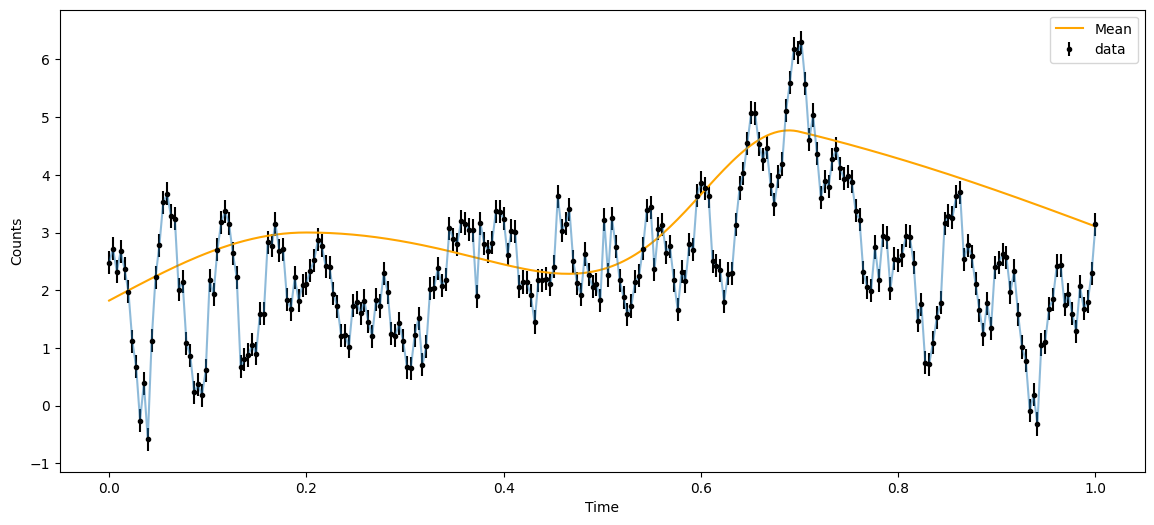

In [2]:
from gpmodelling import get_kernel, get_mean
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

Times = np.linspace(0,1,256)

# We will take suitable parameters for a high amplitude QPO with a double skew gaussian mean
kernel_params  = {"arn" : jnp.exp(1.5),    "crn" : jnp.exp(1.0),
                  "aqpo": jnp.exp(-0.4),    "cqpo": jnp.exp(1),    "freq": 20,}
kernel = get_kernel(kernel_type = "QPO_plus_RN", kernel_params = kernel_params)

mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), 
               "sig1" : jnp.array([0.2, 0.1]), "sig2" : jnp.array([0.3, 0.4]),  }

mean = get_mean(mean_type = "skew_gaussian",  mean_params = mean_params)

jit = 5e-2
gp = GaussianProcess(kernel = kernel, X = Times, mean_value = mean(Times), diag = jit)

# Plotting the GP
counts = sample = gp.sample(key = jax.random.PRNGKey(6))
yerr = (0.2)*np.ones_like(Times)
fig, ax = plt.subplots(1,1, figsize = (14,6))
ax.errorbar(Times, sample.T, yerr=yerr, fmt=".k", capsize=0, label="data")
ax.plot(Times, mean(Times), color = "orange" ,label = "Mean"); ax.legend()
ax.plot(Times, counts, label = "Sample GP", alpha = 0.5)
ax.set_xlabel("Time"); ax.set_ylabel("Counts")

lc = Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0])

We will use the get_prior and get_likelihood functions to make a suitable prior and log_likelihood function for our Inference

* get_gp_params: This function gives us a list of the parameters of the model based on the kernel and mean type we select.

* get_prior_dict: This function will be can be used to get a suitable generater prior function for a jaxns model. We have to give it our parameter list, and a dictionary with suitable tfpd distributions for the priors. 

* get_likelihood: This function will give us a log_likelihood function which calculates the log likelihood probabilty of the data for the given parameter $p(D|\theta, M)$. Here we will have to provide the parameters list, the kernel and mean type of the GP model, as well as the Times and counts of the lightcurve.

In [3]:
import tensorflow_probability.substrates.jax as tfp
from gpmodelling import get_prior, get_likelihood, get_gp_params
tfpd = tfp.distributions
tfpb = tfp.bijectors
params_list = get_gp_params(kernel_type= "RN", mean_type = "gaussian")
print("parameters list", params_list)

counts = sample
T = Times[-1] - Times[0]
f = 1/(Times[1]- Times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "A": tfpd.Uniform(low = 0.1 * span, high = 2 * span),
    "t0": tfpd.Uniform(low = Times[0] - 0.1*T, high = Times[-1] + 0.1*T),
    "sig": tfpd.Uniform(low = 0.5 * 1 / f, high = 2 * T),
    "arn": tfpd.Uniform(low = 0.1 * span, high = 2 * span),
    "crn": tfpd.Uniform(low = jnp.log(1 / T), high = jnp.log(f)),
}

prior_model = get_prior(params_list, prior_dict)
likelihood_model = get_likelihood(params_list, kernel_type= "RN", mean_type = "gaussian", Times = Times, counts = counts)

parameters list ['arn', 'crn', 'A', 't0', 'sig']


We can initialise the GPResult class using a stingray lightcurve, and then perform a Nested Sampling for the given prior_model and likelihood_model.

In [4]:
from gpmodelling import GPResult

Gpresult = GPResult(Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0]))
Gpresult.sample(prior_model = prior_model, likelihood_model = likelihood_model)

INFO[2023-07-20 02:08:10,128]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-07-20 02:08:10,130]: Checking if light curve is sorted.
INFO[2023-07-20 02:08:10,830]: Sanity check...
INFO[2023-07-20 02:08:11,086]: Sanity check passed


Simulation Complete


We can check the Evidence for the data given the model $Z = p(D|M_1)$, as well see the sampling outcomes for the used parameters.

log Evidence:  -214.14012391863545


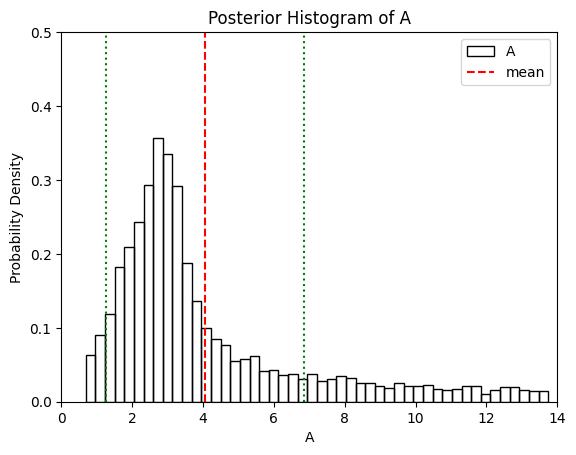

In [5]:
print("log Evidence: ", Gpresult.get_evidence())
plot = Gpresult.posterior_plot("A", axis = [0,14, 0,0.5])
plt.show()

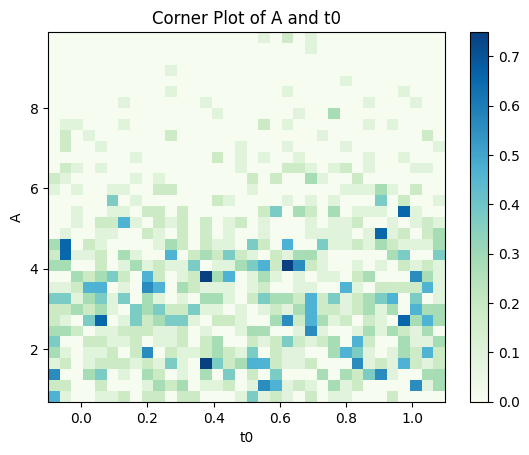

In [9]:
plot = Gpresult.corner_plot("A", "t0", axis = [0,0.5, 0,5])

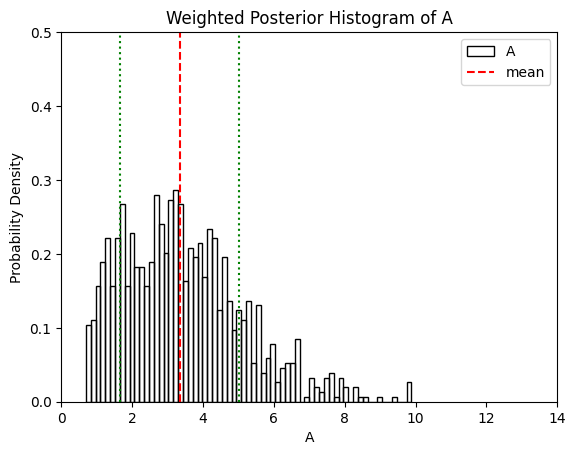

In [6]:
plot = Gpresult.weighted_posterior_plot("A", axis = [0,14, 0,0.5], save = True)
plt.show()

In [7]:
Gpresult.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 151919
# samples: 5500
# slices: 45000.0
# slices / acceptance: 15.0
# likelihood evals / sample: 27.6
# likelihood evals / slice: 3.0
--------
logZ=-214.14 +- 0.074
H=210.0
ESS=1120
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 3.3 +- 1.7 | 1.3 / 3.1 / 5.4 | 2.9 | 2.9
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 9.5 +- 2.0 | 7.2 / 9.1 / 12.6 | 7.9 | 7.9
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 4.25 +- 0.81 | 3.15 / 4.33 / 5.3 | 4.87 | 4.87
--------
sig: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sig: 1.09 +- 0.54 | 0.33 / 1.12 / 1.8 | 0.01 | 0.01
--------
t0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
t0: 0.5 +- 0.35 | 0.02 / 0.52 / 0.99 | 0.7 | 0.7
--------


## Making own priors and log_likelihood functions

We can also construct our own prior and likelihood function, and we will demonstrate the QPO model by constructing our own prior function, and log_likelihood functions.

In [30]:
# QPO prior
from jaxns import Prior
from jaxns.special_priors import ForcedIdentifiability
from jaxns.types import float_type

params_list3 = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")
print(params_list3)

counts = sample
T = Times[-1] - Times[0]
f = 1/(Times[1]- Times[0])
span = jnp.max(counts) - jnp.min(counts)

# Here, we have made mutiple mean function with 2 gaussians.
def prior_model3():
    arn = yield Prior(tfpd.Uniform(low = 0.1 * span, high = 2 * span), name='arn')
    crn = yield Prior(tfpd.Uniform(low = jnp.log(1 / T), high = jnp.log(f)), name='crn')
    aqpo = yield Prior(tfpd.Uniform(low = 0.1 * span, high = 2 * span), name='aqpo')
    cqpo = yield Prior(tfpd.Uniform(low = 1/10/T, high = jnp.log(f)), name='cqpo')
    freq = yield Prior(tfpd.Uniform(low = 2 , high = f/4 ), name='freq')

    n = 2
    A = yield Prior(tfpd.Uniform(low = 0.1 * span*jnp.ones(n), high = 2 * span*jnp.ones(n)), name='A')
    
    # This is special conditional beta function for the peak times of gaussians which prevents degeneracies
    t0 = []
    scale_bij = tfp.bijectors.Scale(scale = Times[-1] - Times[0])
    shift_bij = tfp.bijectors.Shift(shift= Times[0])
    for i in range(n):
        underlying_beta = tfpd.Beta(
            concentration1=jnp.asarray(1., float_type),
            concentration0=jnp.asarray(n - i, float_type)
        )
        t = yield Prior(shift_bij(scale_bij(underlying_beta)), name=f"t{i}")
        # Updating the shift and scale here
        scale_bij = tfp.bijectors.Scale(scale= Times[-1] - t)
        shift_bij = tfp.bijectors.Shift(shift=t)
        t0.append(t)
    t0 = jnp.stack(t0)
    
    sig = yield Prior(tfpd.Uniform(low = 0.5 * 1 / f *jnp.ones(n), high = 2 * T *jnp.ones(n)), name='sig')

    return arn, crn, aqpo, cqpo, freq, A, t0, sig

def likelihood_model3(arn, crn, aqpo, cqpo, freq, A, t0, sig):
    
    kernel_params = { "arn": arn, "crn": crn, "aqpo": aqpo, "cqpo": cqpo, "freq": freq}
    mean_params = {"A": A, "t0": t0, "sig": sig}

    kernel = get_kernel(kernel_type="QPO_plus_RN", kernel_params=kernel_params)
    mean = get_mean(mean_type="gaussian", mean_params=mean_params)
    gp = GaussianProcess(kernel, Times, mean_value=mean(Times))

    return gp.log_probability(counts)


['arn', 'crn', 'aqpo', 'cqpo', 'freq', 'A', 't0', 'sig']


In [31]:
Gpresult3 = GPResult(Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0]))
Gpresult3.sample(prior_model = prior_model3, likelihood_model = likelihood_model3)

INFO[2023-07-11 22:27:03,724]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-07-11 22:27:03,728]: Checking if light curve is sorted.
INFO[2023-07-11 22:27:05,836]: Sanity check...
INFO[2023-07-11 22:27:05,838]: Sanity check passed


Simulation Complete


log Evidence:  -204.0424729376019


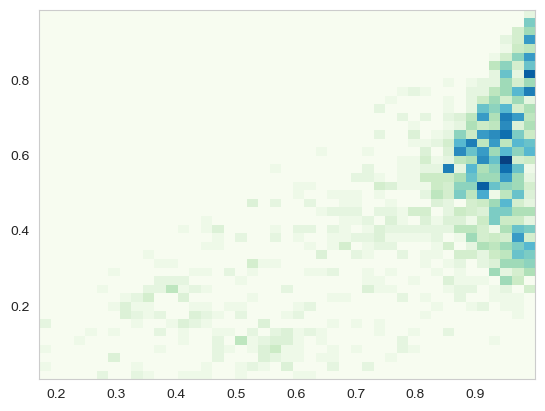

In [32]:
print("log Evidence: ", Gpresult3.get_evidence())

# Corner Plot between the two peak times
Gpresult3.corner_plot("t0", "t1")

On comapring the evidences of the two model we get the Bayes Factor.

For $M_1$ being QPO_plus_RN model and $M_2$ being the plain RN model.

$$
ln(BF) = ln(Z_1) - ln(Z_2) = -204.042 - (-214.292) = 10.25
$$

As BF is greater than 5.0, this gives us a strong indication that the time series has a Quasi Oscillatory behaviour.

Also, as we can see in the weighted posterior plot for the frequency, We had used a frequency of 20 Hz for our sample and this has been captured very well by the Nested Sampling Inference.

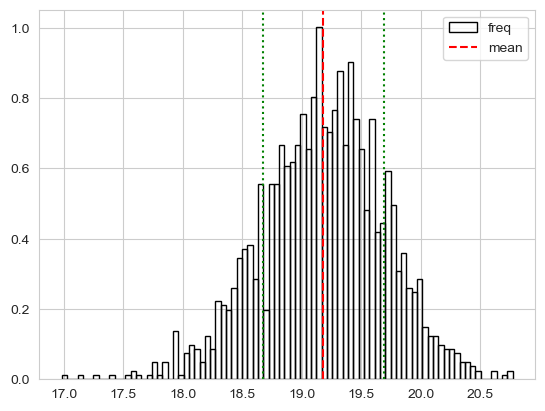

In [159]:
Gpresult3.weighted_posterior_plot("freq")

In [33]:
Gpresult3.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 619069
# samples: 8652
# slices: 238000.0
# slices / acceptance: 34.0
# likelihood evals / sample: 71.6
# likelihood evals / slice: 2.6
--------
logZ=-204.04 +- 0.14
H=200.0
ESS=1815
--------
A[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A[0]: 3.0 +- 1.5 | 1.1 / 2.9 / 5.0 | 1.0 | 1.0
A[1]: 3.4 +- 1.5 | 1.6 / 3.3 / 5.2 | 1.6 | 1.6
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: 1.13 +- 0.62 | 0.72 / 0.94 / 1.73 | 0.8 | 0.8
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 10.8 +- 2.0 | 7.8 / 11.2 / 13.1 | 6.5 | 6.5
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: 1.63 +- 0.84 | 0.58 / 1.62 / 2.61 | 1.47 | 1.47
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 2.79 +- 0.71 | 2.12 / 2.57 / 3.65 | 4.49 | 4.49
--------
f

## Credits:

1. [Gaussian Process regression for astronomical time-series](https://arxiv.org/pdf/2209.08940.pdf), Suzanne Aigrain, Daniel Foreman-Mackey

2. [Bayesian Model Comparison](https://ned.ipac.caltech.edu/level5/Sept13/Trotta/Trotta4.html), Roberto Trotta

3. Searching for quasi-periodic oscillations in astrophysical transients using Gaussian processes, Moritz Hubner et al.